# Wrapup Quiz: Trees

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [6]:
ames_housing = pd.read_csv(
    "../datasets/ames_housing_no_missing.csv",
    na_filter=False,  # required for pandas>2.0
)

target_name = "SalePrice"
data = ames_housing.drop(columns=target_name)
target = ames_housing[target_name]

In [7]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,0,Gd,MnPrv,Shed,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,FR2,...,0,0,Gd,MnPrv,Shed,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0,0,Gd,MnPrv,Shed,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0,0,Gd,MnPrv,Shed,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,Grvl,IR1,Lvl,AllPub,FR2,...,0,0,Gd,MnPrv,Shed,0,12,2008,WD,Normal


In [9]:
target.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [10]:
numerical_features = [
    "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
    "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
]

data_numerical = data[numerical_features]

In [24]:
# define linear model - requires standardisation/scaling
numerical_preprocessor = StandardScaler()
preprocessor = ColumnTransformer(
    [
        ("numerical_preprocessor", numerical_preprocessor, list(data_numerical.columns))
    ],
    remainder="passthrough"
)
linear_model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("linear_regressor", LinearRegression())
    ]
)

# define tree model - scaling has no effect
tree_model = DecisionTreeRegressor(random_state=0)

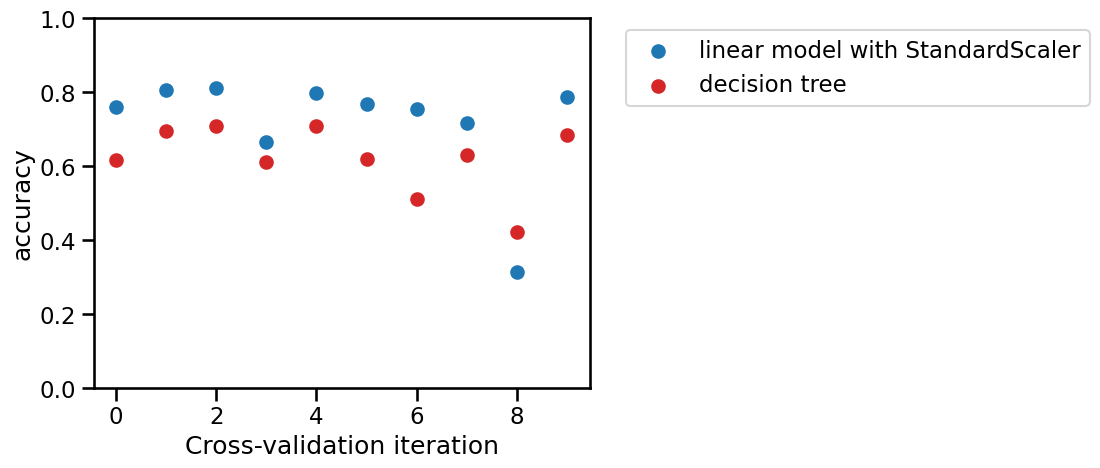

In [ ]:
# q1: compare cv test scores for both models fold-to-fold by counting number of times 
# the linear model has a better test score than decision tree model

# run 10-fold cv (10 test scores) on each model to get variance in our estimate of the
# generalisability of our model
cv_results_linear = cross_validate(
    linear_model, data_numerical, target, cv=10
)
cv_results_tree = cross_validate(
    tree_model, data_numerical, target, cv=10
)

# obtain test scores
cv_test_score_linear = cv_results_linear['test_score']
cv_test_score_tree = cv_results_tree['test_score']

# plot each fold - 0,1,2,3,4
indicies = np.arange(len(cv_test_score_linear))
plt.scatter(
    indicies,
    cv_test_score_linear,
    color="tab:blue",
    label="linear model with StandardScaler",
)
plt.scatter(
    indicies,
    cv_test_score_tree,
    color="tab:red",
    label="decision tree"
)
plt.ylim(0, 1)
plt.xlabel("Cross-validation iteration")
plt.ylabel("accuracy")
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

In [ ]:
# q2: Instead of using the default parameters for the decision tree regressor, we
# can optimize the max_depth of the tree. Vary the max_depth from 1 level up to 15
# levels. Use nested cross-validation to evaluate a grid-search. Set cv=10 for both
# the inner and outer cross-validations, then answer the questions below:

# observe the parameters to tune (find max_depth)
tree_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 0,
 'splitter': 'best'}

In [62]:
# define param_grid
param_grid = {
    'max_depth': list(np.arange(1, 16))
}

# define model for grid search
model_grid_search = GridSearchCV(tree_model, param_grid=param_grid, n_jobs=2, cv=10)

# hold out test set, fit on train set - usually would do
#X_train, X_test, y_train, y_test = train_test_split(data_numerical, target, test_size=0.2, random_state=0)

# nested cv
nested_cv_tree = cross_validate(
    model_grid_search, data_numerical, target, n_jobs=2, return_estimator=True, cv=10
)

# obtain results on best model
nested_cv_tree_results = pd.DataFrame(nested_cv_tree)

In [63]:
# What is the optimal tree depth for the current problem?

# optimal tree depth
for cv_fold, estimator_in_fold in enumerate(nested_cv_tree_results['estimator']):
    print(
        f"The best max_depth hyperparameter in fold {cv_fold} is:\n"
        f"{estimator_in_fold.best_params_}"
    )

The best max_depth hyperparameter in fold 0 is:
{'max_depth': np.int64(5)}
The best max_depth hyperparameter in fold 1 is:
{'max_depth': np.int64(7)}
The best max_depth hyperparameter in fold 2 is:
{'max_depth': np.int64(6)}
The best max_depth hyperparameter in fold 3 is:
{'max_depth': np.int64(6)}
The best max_depth hyperparameter in fold 4 is:
{'max_depth': np.int64(8)}
The best max_depth hyperparameter in fold 5 is:
{'max_depth': np.int64(6)}
The best max_depth hyperparameter in fold 6 is:
{'max_depth': np.int64(7)}
The best max_depth hyperparameter in fold 7 is:
{'max_depth': np.int64(8)}
The best max_depth hyperparameter in fold 8 is:
{'max_depth': np.int64(7)}
The best max_depth hyperparameter in fold 9 is:
{'max_depth': np.int64(6)}


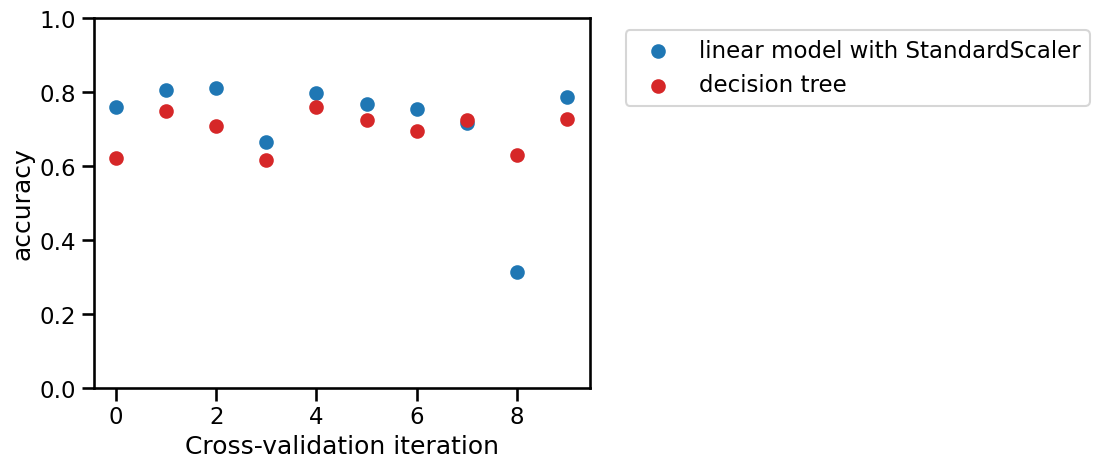

In [64]:
# q3: 

# run 10-fold cv (10 test scores) on each model to get variance in our estimate of the
# generalisability of our model
cv_results_linear = cross_validate(
    linear_model, data_numerical, target, cv=10
)

# obtain test scores
cv_test_score_linear = cv_results_linear['test_score']
nested_cv_test_score_tree = nested_cv_tree['test_score']

# plot each fold - 0,1,2,3,4
indicies = np.arange(len(cv_test_score_linear))
plt.scatter(
    indicies,
    cv_test_score_linear,
    color="tab:blue",
    label="linear model with StandardScaler",
)
plt.scatter(
    indicies,
    nested_cv_test_score_tree,
    color="tab:red",
    label="decision tree"
)
plt.ylim(0, 1)
plt.xlabel("Cross-validation iteration")
plt.ylabel("accuracy")
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

A tree with an optimized depth is better than linear regression for 2 CV iterations out of 10 folds.

A tree model using both numerical and categorical features is better than a tree with optimal depth using only numerical features for 7 CV iterations out of 10 folds.


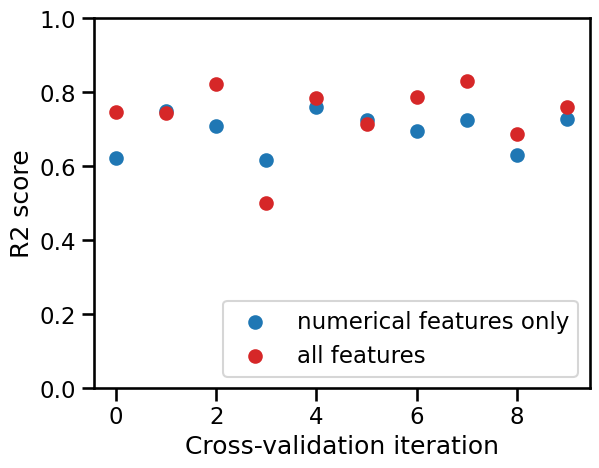

In [87]:
# define model with numerical & categorical features:
categorical_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = make_column_transformer(
    (categorical_processor, selector(dtype_include=object)),
    ("passthrough", numerical_features)
)
tree = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth=7, random_state=0))

# perform cv on model with numerical & categorical features:
cv_results = cross_validate(
    tree, data, target, cv=10, return_estimator=True, n_jobs=2
)
cv_results["test_score"].mean()

# obtain array of test_scores
test_score_num = nested_cv_test_score_tree
test_score_all = cv_results["test_score"]

# plot test scores
indices = np.arange(len(test_score_num))
plt.scatter(
    indices, test_score_num, color="tab:blue", label="numerical features only"
)
plt.scatter(
    indices,
    test_score_all,
    color="tab:red",
    label="all features",
)
plt.ylim((0, 1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("R2 score")
_ = plt.legend(loc="lower right")

print(
    "A tree model using both numerical and categorical features is better than a "
    "tree with optimal depth using only numerical features for "
    f"{sum(cv_results['test_score'] > nested_cv_test_score_tree)} CV "
    "iterations out of 10 folds."
)

The model with all features performs better than the max_depth tuned model with just numerical features for 7 out of 10 CV-folds.